In [8]:
%matplotlib inline
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import torch

In [9]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# config

In [13]:
from dataset import SiameseNetworkDataset
from siamese import SiameseNetwork

class Config():
    training_dir = "../dataset/siamese_dataset/train"
    testing_dir = "../dataset/siamese_dataset/test"
    train_batch_size = 64
    train_number_epochs = 300

In [14]:
folder_dataset = datasets.ImageFolder(root=Config.training_dir)

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                    transforms.RandomAffine(30),
                                                                    transforms.ToTensor()]),
                                        should_invert=False)

torch.Size([8, 3, 100, 100])


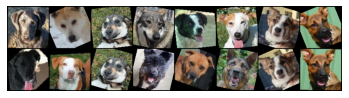

[[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]]


In [18]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
print(example_batch[0].shape)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

# train

In [20]:
from dataset import SiameseNetworkDataset
from siamese import SiameseNetwork, ContrastiveLoss

class Config():
    training_dir = "../dataset/siamese_dataset/train"
    testing_dir = "../dataset/siamese_dataset/test"
    train_batch_size = 64
    train_number_epochs = 300
    lr_rate = 0.0005
    save_path = './save_model/'
    

folder_dataset = datasets.ImageFolder(root=Config.training_dir)

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                    transforms.RandomAffine(30),
                                                                    transforms.ToTensor()]),
                                        should_invert=False)

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)
data_size = len(train_dataloader)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=Config.lr_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

lowest_loss = 0.5
loss_history = []
epoch_loss_his = []

for epoch in range(Config.train_number_epochs):
    running_loss = 0.0
    for batch, data in enumerate(train_dataloader):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0, img1)
        loss_contrastive = criterion(output1,output2,label)

        loss_contrastive.backward()
        optimizer.step()

        running_loss += loss_contrastive.item()
        loss_history.append(loss_contrastive.item())

    epoch_loss = float(running_loss / data_size)
    epoch_loss_his.append(epoch_loss)
    print(f"Epoch {epoch} epoch_loss {epoch_loss}")
    
    if epoch_loss < lowest_loss:
        lowest_loss = epoch_loss
        state = {'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss}
        file_path = Config.save_path + f'{epoch}_{lowest_loss:.3f}.pth'
        torch.save(net, file_path)
        print(f'Save model_ [loss : {epoch_loss:.4f}, save_path : {file_path}]')

    if lowest_loss < 0.00001:
            break

Epoch 0 epoch_loss 1.2834833567425357
Epoch 1 epoch_loss 0.7512256341465449
Epoch 2 epoch_loss 0.6616132628109496
Epoch 3 epoch_loss 0.6141966263116416
Epoch 4 epoch_loss 0.5517036455162501
Epoch 5 epoch_loss 0.5333399838310177
Epoch 6 epoch_loss 0.48119886547832164
Save model_ [loss : 0.4812, save_path : ./save_model/6_0.481.pth]
Epoch 7 epoch_loss 0.47272330118437944
Save model_ [loss : 0.4727, save_path : ./save_model/7_0.473.pth]
Epoch 8 epoch_loss 0.4564173231690617
Save model_ [loss : 0.4564, save_path : ./save_model/8_0.456.pth]
Epoch 9 epoch_loss 0.4321550438969822
Save model_ [loss : 0.4322, save_path : ./save_model/9_0.432.pth]
Epoch 10 epoch_loss 0.42278944486278597
Save model_ [loss : 0.4228, save_path : ./save_model/10_0.423.pth]
Epoch 11 epoch_loss 0.4124960333614026
Save model_ [loss : 0.4125, save_path : ./save_model/11_0.412.pth]
Epoch 12 epoch_loss 0.4127686746039633
Epoch 13 epoch_loss 0.3930876633878482
Save model_ [loss : 0.3931, save_path : ./save_model/13_0.393.p

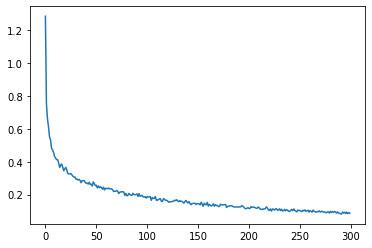

In [21]:
show_plot(range(300),epoch_loss_his)

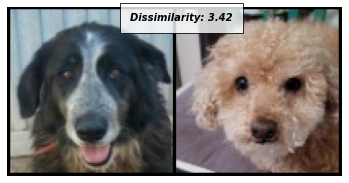

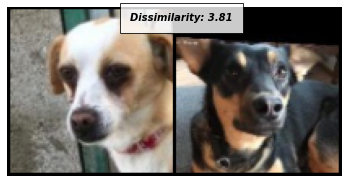

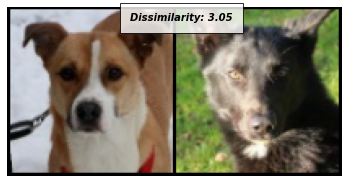

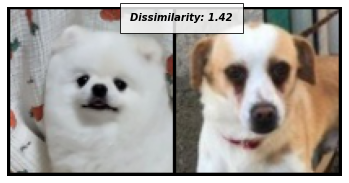

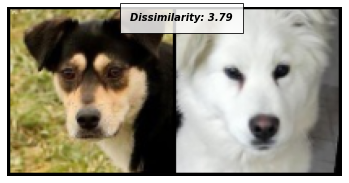

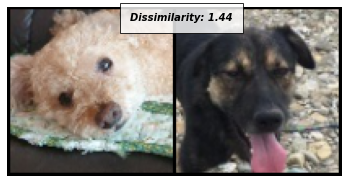

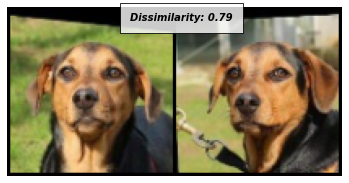

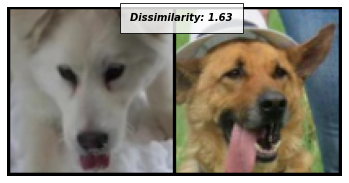

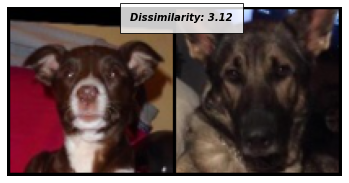

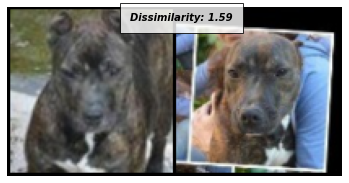

In [22]:
from torch.autograd import Variable
import torch.nn.functional as F

folder_dataset_test = datasets.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                    transforms.ToTensor()])
                                        ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
# x0,_, = next(dataiter)

for i in range(10):
    x0,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

In [ ]:
from dataset import SiameseNetworkDataset
from siamese import SiameseNetwork, ContrastiveLoss

class Config():
    training_dir = "../dataset/siamese_dataset/train"
    testing_dir = "../dataset/siamese_dataset/test"
    train_batch_size = 64
    train_number_epochs = 300
    lr_rate = 0.0005
    save_path = './save_model/'
    

folder_dataset = datasets.ImageFolder(root=Config.training_dir)

siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                    transforms.RandomHorizontalFlip(p=1),
                                                                    transforms.RandomAffine(30),
                                                                    transforms.ToTensor()]),
                                        should_invert=False)

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=Config.train_batch_size)
data_size = len(train_dataloader)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=Config.lr_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

lowest_loss = 0.5
loss_history = []
epoch_loss_his = []

for epoch in range(Config.train_number_epochs):
    running_loss = 0.0
    for batch, data in enumerate(train_dataloader):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0, img1)
        loss_contrastive = criterion(output1,output2,label)

        loss_contrastive.backward()
        scheduler.step()

        running_loss += loss_contrastive.item()
        loss_history.append(loss_contrastive.item())

    epoch_loss = float(running_loss / data_size)
    epoch_loss_his.append(epoch_loss)
    print(f"Epoch {epoch} epoch_loss {epoch_loss}")
    
    if epoch_loss < lowest_loss:
        lowest_loss = epoch_loss
        state = {'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss}
        file_path = Config.save_path + f'{epoch}_{lowest_loss:.3f}.pth'
        torch.save(net, file_path)
        print(f'Save model_ [loss : {epoch_loss:.4f}, save_path : {file_path}]')

    if lowest_loss < 0.00001:
            break